In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing, ensemble, linear_model, metrics
import xgboost as xgb

In [2]:
df_train = pd.read_csv('./data/sentiment_analysis_trainingset.csv')

In [3]:
df_valid = pd.read_csv('./data/sentiment_analysis_validationset.csv')

In [4]:
df_testa = pd.read_csv('./data/sentiment_analysis_testa.csv')

In [4]:
df_train.head(2)

,id,content,location_traffic_convenience,location_distance_from_business_district,location_easy_to_find,service_wait_time,service_waiters_attitude,service_parking_convenience,service_serving_speed,price_level,...,environment_decoration,environment_noise,environment_space,environment_cleaness,dish_portion,dish_taste,dish_look,dish_recommendation,others_overall_experience,others_willing_to_consume_again
0,0,"""吼吼吼，萌死人的棒棒糖，中了大众点评的霸王餐，太可爱了。一直就好奇这个棒棒糖是怎么个东西，...",-2,-2,-2,-2,1,-2,-2,-2,...,-2,-2,-2,-2,-2,-2,1,-2,1,-2
1,1,"""第三次参加大众点评网霸王餐的活动。这家店给人整体感觉一般。首先环境只能算中等，其次霸王餐提...",-2,-2,-2,-2,-2,-2,-2,0,...,0,0,0,0,1,-2,-2,-2,1,-2


In [6]:
df_train.shape

(105000, 22)

In [7]:
print(df_train[df_train['location_traffic_convenience'] == -1].iloc[1,1])

"和小伙伴一起约的日料放题 一开始也没有想好去哪里 点评里搜索日料 第一家跳出的就是它 看着点评还不错 就一起去拔草了 先说说地理位置吧 自家开车的话还比较方便 如果是地铁之类的交通工具的话 太不方便了啦 下来要走好长段路 而且在条小路里面 比较隐蔽 比较难找 不过吃的人还很多呢 应该是他家东西好 再来具体说说菜品吧 他家有刺身 烤物 还有铁板 可以自己烤 前面几轮肯定是刺身啦 提前告知了说海胆没有 说是季节不好 有点小失望呢 送了个叫啥梅子酒红毛蟹 感觉一般般 太甜了 傲虾 金枪鱼鱼腹 小青龙都是限量的 三文鱼鱼腩 北极贝（超大的）牡丹虾（畅食）甜虾 扇贝 田螺？都很新鲜 肉质都很甜 质量很不错 叫了好几轮 后面点了些烤物 银鳕鱼（超好吃的） 鳗鱼 蟹宝都蛮赞的 关键他还不限时 聊聊天 可以吃超久的 后来还点了些牛舌 牛仔骨之类的 自己烤 还送了个限量的雪花牛肉 很嫩 油脂很丰富 相对于这个价格来讲 觉得性价比是蛮高的 希望店家以后继续保持这种质量 还希望下次来的时候可以吃到海胆"


## 查看每个类别占比，数据平衡性问题

In [8]:
data_size = len(df_train)
colnames = df_train.columns[2:]
num_type = len(colnames)

sum_0, sum_1, sum_2, sum_3 = 0, 0, 0, 0
# 查看所有数据的类别分布
for colname in colnames:
    sum_0 += np.sum(df_train[colname] == 1)
    sum_1 += np.sum(df_train[colname] == 0)
    sum_2 += np.sum(df_train[colname] == -1)
    sum_3 += np.sum(df_train[colname] == -2)
print('>>> class distribution in total data:')
print('class  1: {:5.2f}%'.format(sum_0/data_size/num_type*100))
print('class  0: {:5.2f}%'.format(sum_1/data_size/num_type*100))
print('class -1: {:5.2f}%'.format(sum_2/data_size/num_type*100))
print('class -2: {:5.2f}%'.format(sum_3/data_size/num_type*100))
print()

print('============================================================\n')

# 查看每个细粒度中类别的分布
print('>>> class distribution in each type:')
for i in range(len(colnames)):
    colname = colnames[i]
    sum_0 = np.sum(df_train[colname] == 1)
    sum_1 = np.sum(df_train[colname] == 0)
    sum_2 = np.sum(df_train[colname] == -1)
    sum_3 = np.sum(df_train[colname] == -2)
    print('type{}: {}'.format(i+1, colname))
    print('class  1: {:5.2f}%'.format(sum_0/data_size*100))
    print('class  0: {:5.2f}%'.format(sum_1/data_size*100))
    print('class -1: {:5.2f}%'.format(sum_2/data_size*100))
    print('class -2: {:5.2f}%'.format(sum_3/data_size*100))
    print()

>>> class distribution in total data:
class  1: 24.45%
class  0:  8.64%
class -1:  4.30%
class -2: 62.62%


>>> class distribution in each type:
type1: location_traffic_convenience
class  1: 20.24%
class  0:  1.00%
class -1:  1.26%
class -2: 77.51%

type2: location_distance_from_business_district
class  1: 19.24%
class  0:  0.51%
class -1:  0.56%
class -2: 79.70%

type3: location_easy_to_find
class  1: 17.09%
class  0:  2.35%
class -1:  3.79%
class -2: 76.77%

type4: service_wait_time
class  1:  4.59%
class  0:  4.17%
class -1:  2.89%
class -2: 88.35%

type5: service_waiters_attitude
class  1: 39.40%
class  0: 11.94%
class -1:  8.27%
class -2: 40.39%

type6: service_parking_convenience
class  1:  3.76%
class  0:  1.39%
class -1:  1.26%
class -2: 93.60%

type7: service_serving_speed
class  1:  8.03%
class  0:  2.27%
class -1:  5.23%
class -2: 84.48%

type8: price_level
class  1: 14.82%
class  0: 23.09%
class -1: 11.79%
class -2: 50.30%

type9: price_cost_effective
class  1: 17.79%
class

In [5]:
# 获取某一个粒度下每个类别的样本
colnames = df_train.columns[2:]
colname = colnames[10]
print(colname)
contents_all = list(df_train['content'])
contents_1 = list(df_train[df_train[colname] == 1]['content'])
contents_0 = list(df_train[df_train[colname] == 0]['content'])
contents__1 = list(df_train[df_train[colname] == -1]['content'])
contents__2 = list(df_train[df_train[colname] == -2]['content'])
print(' 1 : {}'.format(len(contents_1)))
print(' 0 : {}'.format(len(contents_0)))
print('-1 : {}'.format(len(contents__1)))
print('-2 : {}'.format(len(contents__2)))
print(contents_0[0])

environment_decoration
 1 : 39453
 0 : 9492
-1 : 2139
-2 : 53916
"第三次参加大众点评网霸王餐的活动。这家店给人整体感觉一般。首先环境只能算中等，其次霸王餐提供的菜品也不是很多，当然商家为了避免参加霸王餐吃不饱的现象，给每桌都提供了至少六份主食，我们那桌都提供了两份年糕，第一次吃火锅会在桌上有这么多的主食了。整体来说这家火锅店没有什么特别有特色的，不过每份菜品分量还是比较足的，这点要肯定！至于价格，因为没有看菜单不了解，不过我看大众有这家店的团购代金券，相当于7折，应该价位不会很高的！最后还是要感谢商家提供霸王餐，祝生意兴隆，财源广进"


### 句子长度分析

In [6]:
np.max([len(contents_all[i]) for i in range(len(contents_all))])

2004

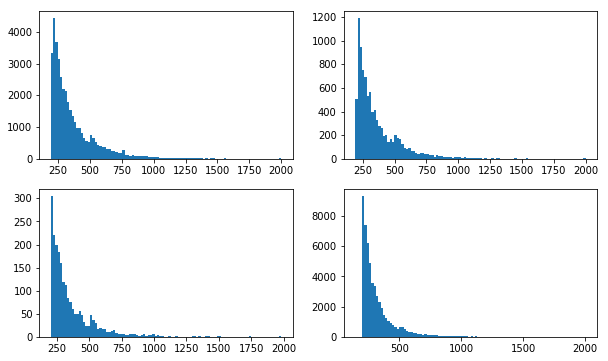

In [7]:
plt.figure(figsize=(10,6))
contents_list = [contents_1, contents_0, contents__1, contents__2]
for i in range(len(contents_list)):
    contents = contents_list[i]
    lens = [len(contents[j]) for j in range(len(contents))]
    plt.subplot(2, 2, i+1)
    plt.hist(lens, bins=100)
plt.show()

In [12]:
lens_1 = [len(s) for s in contents_1]
lens_0 = [len(s) for s in contents_0]
lens__1 = [len(s) for s in contents__1]
lens__2 = [len(s) for s in contents__2]
print('mean:')
print(np.mean(lens_1))
print(np.mean(lens_0))
print(np.mean(lens__1))
print(np.mean(lens__2))
print('\nmin:')
print(np.min(lens_1))
print(np.min(lens_0))
print(np.min(lens__1))
print(np.min(lens__2))
print('\nmax:')
print(np.max(lens_1))
print(np.max(lens_0))
print(np.max(lens__1))
print(np.max(lens__2))
print('\nstd:')
print(np.std(lens_1))
print(np.std(lens_0))
print(np.std(lens__1))
print(np.std(lens__2))

mean:
380.32245963551566
370.27022756005056
354.63534361851333
321.6099859039988

min:
194
190
202
144

max:
2002
2002
1984
2004

std:
219.6587194938255
201.5602467412763
179.73635771128903
151.56104232568893


### 类别之间的关系分析

In [13]:
col_classes = df_train.columns[2:]
df_classes = df_train[col_classes]
df_classes.head()

,location_traffic_convenience,location_distance_from_business_district,location_easy_to_find,service_wait_time,service_waiters_attitude,service_parking_convenience,service_serving_speed,price_level,price_cost_effective,price_discount,environment_decoration,environment_noise,environment_space,environment_cleaness,dish_portion,dish_taste,dish_look,dish_recommendation,others_overall_experience,others_willing_to_consume_again
0,-2,-2,-2,-2,1,-2,-2,-2,-2,1,-2,-2,-2,-2,-2,-2,1,-2,1,-2
1,-2,-2,-2,-2,-2,-2,-2,0,-2,1,0,0,0,0,1,-2,-2,-2,1,-2
2,-2,-2,-2,-2,0,-2,1,0,-2,1,-2,-2,1,-2,0,1,-2,-2,0,-2
3,-2,-2,-2,-2,-2,-2,-2,0,-2,-2,-2,-2,-2,-2,-2,-1,-2,-2,-1,-1
4,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,1,1,-2,1,-2


In [18]:
y = np.array(df_classes['others_overall_experience'])
x = np.array(df_classes[col_classes.drop('others_overall_experience')])
print(x.shape)
print(y.shape)

(105000, 19)
(105000,)


In [29]:
mat = np.array(df_classes)

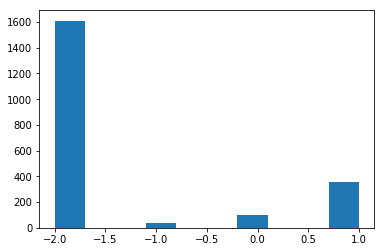

## 转换原始数据为全类别模式

In [ ]:
col_names = df.columns[2:]
df_new = df[df.columns[:2]]
for col_name in col_names:
    df_one_new = pd.get_dummies(df[col_name], prefix=col_name)
    cols = df_one_new.columns
    cols = cols[::-1]
    df_one_new = df_one_new[cols]
    df_new = pd.concat([df_new, df_one_new], axis=1)

In [ ]:
df_new

In [ ]:
df_new.shape

In [ ]:
# write out train dataset
df_new.to_csv(path_or_buf='./data/df_train.csv', header=True, index=False)

In [ ]:
# write out valid dataset
df_new.to_csv(path_or_buf='./data/df_valid.csv', header=True, index=False)

In [ ]:
# write out testa dataset
df_new.to_csv(path_or_buf='./data/df_testa.csv', header=True, index=False)

In [ ]:
df_new['content'].iloc[0]

In [ ]:
df_new[df_new.columns[2:]].shape

In [ ]:
df_new[:2]

In [ ]:
df_testa_pred = pd.read_csv('./data/df_testa_pred.csv')

In [ ]:
df_testa_pred

In [ ]:
df_testa_pred.shape

In [ ]:
df_testa_pred[df_testa_pred.columns[2:]][0:3]

## 查看valid set推测结果

In [ ]:
df_valid = pd.read_csv('./data/df_valid.csv')
df_valid_pred = pd.read_csv('./data/df_valid_pred.csv')

In [ ]:
idx = 2

In [ ]:
print(df_valid['content'].iloc[idx])

In [ ]:
pd.concat([df_valid.iloc[idx, 2:], df_valid_pred.iloc[idx, 2:]], axis=1)

In [ ]:
# 查看真值和推测值每个粒度下类别unique值
for i in range(20):
    print('{:2}: true: {}, pred: {}'.format(i+1, df_valid.iloc[:, i+2].unique(), df_valid_pred.iloc[:, i+2].unique()))

In [ ]:
np.sum(df_valid.iloc[:, 2] == 0)

In [ ]:
np.sum(df_valid_pred.iloc[:, 2] == 0)

## check df_testa_pred

In [ ]:
df_testa_pred = pd.read_csv('./data/df_testa_pred.csv')

In [ ]:
df_testa_pred.shape

In [ ]:
for i in range(20):
    print('{:2}: pred: {}'.format(i+1, df_testa_pred.iloc[:, i+2].unique()))

In [ ]:
idx = 101

In [ ]:
print(df_testa_pred['content'].iloc[idx])

In [ ]:
pd.DataFrame(df_testa_pred.iloc[idx, 2:])